In [22]:
import sys
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/semi_supervised/')
import coreg
reload(coreg)
import trireg
reload(trireg)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ordinal/')
import simple
reload(simple)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ensemble/')
import stacking
reload(stacking)

import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

import transformers as tforms
reload(tforms)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import metrics
reload(metrics)
from sklearn.cross_validation import StratifiedKFold, train_test_split

from sklearn.base import clone

from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from collections import Counter
import minirank as mr

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

import cPickle as pickle

def wgmean(x, w):
    return np.exp(np.sum(w*np.log(x), axis=1) / np.sum(w, axis=1))

In [3]:
# Load Data custom
train_pd  = pd.read_pickle('saved/train_pd_custom.p')
test_pd  = pd.read_pickle('saved/test_pd_custom.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')

In [2]:
# Load Data le instead

# train_pd  = pd.read_pickle('saved/train_pd_l_enc.p')
# test_pd  = pd.read_pickle('saved/test_pd_l_enc.p')

train_pd  = pd.read_pickle('saved/train_pd_le_and_oh_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_le_and_oh_enc.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')
fi = np.load('saved/feature_importances.npy')

y_binned[y_binned==6] = 5

drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = []

# drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)

In [81]:
from svmlight_loader import dump_svmlight_file, load_svmlight_file
# mapped_train, _y = load_svmlight_file('saved/mapped2000_train.libsvm')
# X_2000mean = mapped_train.todense()

mapped_train, _y = load_svmlight_file('saved/mapped1000_train_79.libsvm')
X_1000mean = mapped_train.todense()


In [31]:
y_binned[y_binned==6] = 5

train = np.array(train_pd)
test = np.array(test_pd)

X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)

try:
    X_train = np.c_[X_train, X_tsne2_train]
    X_test = np.c_[X_test, X_tsne2_test]
except:
    pass

holdout = False
if holdout:
    X_train, X_hold, \
    y_train, y_hold, \
    y_binned, y_binned_hold \
    = train_test_split(
        X_train, y_train, y_binned, 
        test_size=0.2, random_state=0)


pipe_x = make_pipeline(
    make_union(
        tforms.IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ),
    StandardScaler(),
)
pipe_y = make_pipeline(
#     tforms.IdentityTformer(),
#     tforms.BoxCoxTformer(),
#     tforms.LogTfortforms.mer(),
#     tforms.AnscombeTformer(),
#     tforms.FreemanTukeyTformer(),
#     tforms.ArcsinhTformer(),
#     StandardScaler(),
    tforms.GeneralTformer(lambda x: np.log(x)),
)
pipe_x.fit(np.r_[X_train, X_test])


X_train = pipe_x.transform(X_train)
X_test = pipe_x.transform(X_test)
try:
    X_hold = pipe_x.transform(X_hold)
except:
    pass

y_train_orig = y_train
y_train = pipe_y.fit_transform(y_train)



# small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]
# y_binned = y_binned[:small_n]

print 'y_train', y_train.shape
print 'X_train', X_train.shape
print 'X_test', X_test.shape
try:
    print 'X_hold', X_hold.shape
except:
    pass
print len(np.unique(y_train))
print len(np.unique(y_binned))
print type(X_train[0][0])

y_train (50999,)
X_train (50999, 79)
X_test (51000, 79)
X_hold 50
5
<type 'numpy.float64'>


# Keras

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, MaxoutDense, Reshape
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adadelta, Adagrad, Adam, RMSprop
from keras.layers.advanced_activations import ParametricSoftplus, PReLU

Using gpu device 0: GeForce GTX 580


In [83]:
big = False

if big:
    X = np.c_[X_1000mean, X_train]
else:
    X = X_train
print X.shape



(50999, 79)


In [90]:
# n_feats = X_train.shape[1]
n_feats = X.shape[1]
drop_prob = 0.5

model = Sequential()

# # for 79 feats
# hidden_size = 256
# model.add(Dense(n_feats, hidden_size))
# model.add(Dropout(0.2))
# model.add(ParametricSoftplus(hidden_size))
# model.add(BatchNormalization((hidden_size,)))
# model.add(Dropout(drop_prob))
# model.add(Dense(hidden_size, hidden_size))
# model.add(ParametricSoftplus(hidden_size))
# model.add(BatchNormalization((hidden_size,)))
# model.add(Dropout(drop_prob))
# model.add(Dense(hidden_size, hidden_size))
# model.add(ParametricSoftplus(hidden_size))
# model.add(BatchNormalization((hidden_size,)))
# model.add(Dropout(drop_prob))
# model.add(Dense(hidden_size, hidden_size))
# model.add(ParametricSoftplus(hidden_size))
# model.add(BatchNormalization((hidden_size,)))
# model.add(Dropout(drop_prob))
# model.add(Dense(hidden_size, 1))
# model.add(Activation('linear'))

# for 1000 feats
hidden_size = 1024
model.add(Dense(n_feats, hidden_size))
model.add(Dropout(0.2))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
model.add(ParametricSoftplus(hidden_size))
model.add(BatchNormalization((hidden_size,)))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, 1))
model.add(Activation('linear'))

# loss_type = 'mae
# loss_type = 'msle'
loss_type = 'mse'


# opt = RMSprop(lr=0.0005, rho=0.75, epsilon=1e-6)
opt = RMSprop(lr=0.001, rho=0.75, epsilon=1e-6)

model.compile(loss=loss_type, optimizer=opt)
model.save_weights('saved/nn_weights', overwrite=True)

In [91]:
# clf = KerasClassifier(model=model, optimizer='rmsprop', loss=loss_type)

losses = []
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
# clf = ElasticNet()

scores = []
scores_base = []
n_reps = 1
k = 5
for reps in range(n_reps):
    skf = StratifiedKFold(y_binned, n_folds=k,
                          shuffle=True,
                          random_state=np.random.randint(0,100))
    for ii, (train, valid) in enumerate(skf):
        model.load_weights('saved/nn_weights')
        
        
        history = LossHistory()   # for keras
        print 'Fold %d' % ii,
#         X_train_k = X_train[train]
#         X_valid_k = X_train[valid]
        X_train_k = X[train]
        X_valid_k = X[valid]
        y_train_k = y_train[train]
        y_valid_k = y_train[valid]
#         y_train_k = y_binned[train]
#         y_valid_k = y_binned[valid]
        y_valid_k_orig = y_train_orig[valid]
        
        tic = time()
    
        model.fit(X_train_k, y_train_k, 
                  nb_epoch=400, batch_size=1024*4,
                  validation_data=(X_valid_k, y_valid_k),
                  callbacks=[history],
                  verbose=2)
        
        toc = time() - tic
        print 'Train time: %2.3f s\t' % toc, 

#         valid_preds = clf.predict(X_valid_k)
#         valid_preds = clf.predict_proba(X_valid_k, batch_size=16384).flatten()
        valid_preds = model.predict_proba(X_valid_k, batch_size=1024*16, verbose=0).flatten()
        
#         score = metrics.gini(y_valid_k, valid_preds)
        score = metrics.normalized_gini(y_valid_k_orig, valid_preds)
        
        print 'Score %1.5f' % score
        scores.append(score)
        
        losses.append(history.losses)
        
        break
        
print "done"
print np.array(scores).mean()

Fold 0Train on 40797 samples, validate on 10202 samples
Epoch 0
2s - loss: 1.6184 - val_loss: 1.4651
Epoch 1
2s - loss: 1.3481 - val_loss: 1.1953
Epoch 2
2s - loss: 1.0706 - val_loss: 0.9148
Epoch 3
2s - loss: 0.8401 - val_loss: 0.8052
Epoch 4
2s - loss: 0.8218 - val_loss: 0.8075
Epoch 5
2s - loss: 0.8328 - val_loss: 0.7935
Epoch 6
2s - loss: 0.8225 - val_loss: 0.7852
Epoch 7
2s - loss: 0.8184 - val_loss: 0.7843
Epoch 8
2s - loss: 0.8092 - val_loss: 0.7835
Epoch 9
2s - loss: 0.8066 - val_loss: 0.7773
Epoch 10
2s - loss: 0.7960 - val_loss: 0.7784
Epoch 11
2s - loss: 0.7924 - val_loss: 0.7724
Epoch 12
2s - loss: 0.7821 - val_loss: 0.7627
Epoch 13
2s - loss: 0.7843 - val_loss: 0.7637
Epoch 14
2s - loss: 0.7806 - val_loss: 0.7642
Epoch 15
2s - loss: 0.7733 - val_loss: 0.7645
Epoch 16
2s - loss: 0.7743 - val_loss: 0.7602
Epoch 17
2s - loss: 0.7711 - val_loss: 0.7572
Epoch 18
2s - loss: 0.7695 - val_loss: 0.7562
Epoch 19
2s - loss: 0.7700 - val_loss: 0.7593
Epoch 20
2s - loss: 0.7669 - val_l

0.330660336745
[ 0.33066034]


(0.72, 0.76)

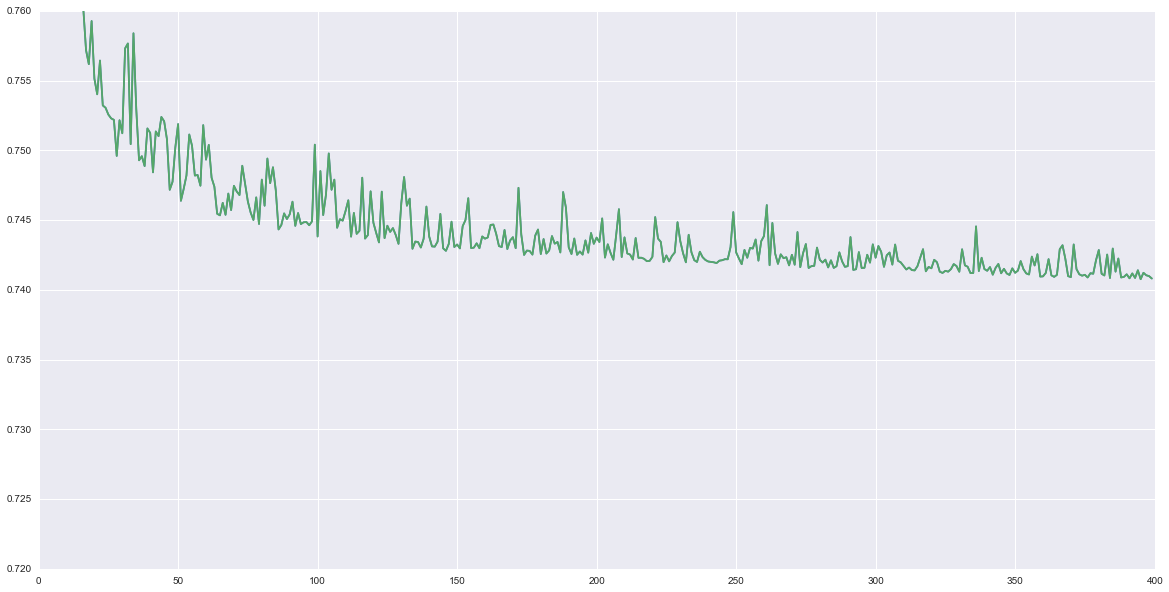

In [92]:
plt.figure(figsize=(20,10))
print np.array(scores).mean()
print np.array(scores)
plt.plot(np.mean(losses, axis=0))
plt.plot(np.array(losses).T)
plt.ylim([0.72, 0.76])
# plt.ylim([1.43, 1.5])
# plt.ylim([14.5, 15.5])
# plt.ylim([0.39, 0.45])

[ 2.72351503  3.22279859  2.74496603  4.32277489  3.4688468   4.8109026
  2.28649879  2.8852489   2.24739313  2.19923973]
[ 1  1  5 15  1 14  1  1  4  7]


In [21]:
# 0.345 @ 512 maxout
# 0.365419697668  1000 clusters & original feats

{'loss': 'mean_absolute_error',
 'model': <keras.models.Sequential at 0x7f72ef18dbd0>,
 'optimizer': 'rmsprop'}

# Predict Test Set

In [60]:
model.compile(loss=loss_type, optimizer='rmsprop')
model.fit(X_train, y_train, 
          nb_epoch=10, batch_size=16384,
          callbacks=[history],
          verbose=0)

preds = model.predict_proba(X_test, batch_size=16384, verbose=0).flatten()

In [62]:
print preds.shape
print X_test.shape

(51000,)
(51000, 111)


# Generate submission

In [63]:
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('submissions/keras_benchmark.csv')